# 10-6 ResNet for cifar10

## original code is =>
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

In [1]:
import torch
import torch.nn as nn

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

C:\Users\wjsrn\anaconda3\envs\py39t116\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import visdom

vis = visdom.Visdom()
vis.close(env="main")

Setting up a new session...


''

## define value tracker

In [3]:
def value_tracker(value_plot, value, num):
    '''num, loss_value, are Tensor'''
    vis.line(X=num,
             Y=value,
             win = value_plot,
             update='append'
             )

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

## transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

### How to Calculate mean and std in Normalize 

In [6]:
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

print(trainset.data.shape)

train_data_mean = trainset.data.mean( axis=(0,1,2) )
train_data_std = trainset.data.std( axis=(0,1,2) )


print(train_data_mean)
print(train_data_std)

train_data_mean = train_data_mean / 255
train_data_std = train_data_std / 255

print(train_data_mean)
print(train_data_std)

Files already downloaded and verified
(50000, 32, 32, 3)
[125.30691805 122.95039414 113.86538318]
[62.99321928 62.08870764 66.70489964]
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [7]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(train_data_mean, train_data_std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_data_mean, train_data_std)
])

In [9]:
trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## make ResNet50 using resnet.py

In [10]:
import torchvision.models.resnet as resnet

In [11]:
conv1x1=resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock= resnet.BasicBlock

In [12]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        #self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 16, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 32, layers[1], stride=1)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 128, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        #x.shape =[1, 16, 32,32]
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.maxpool(x)

        x = self.layer1(x)
        #x.shape =[1, 128, 32,32]
        x = self.layer2(x)
        #x.shape =[1, 256, 32,32]
        x = self.layer3(x)
        #x.shape =[1, 512, 16,16]
        x = self.layer4(x)
        #x.shape =[1, 1024, 8,8]
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [13]:
resnet50 = ResNet(resnet.Bottleneck, [3, 4, 6, 3], 10, True).to(device) 
#1(conv1) + 9(layer1) + 12(layer2) + 18(layer3) + 9(layer4) +1(fc)= ResNet50

In [14]:
resnet50

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [15]:
a=torch.Tensor(1,3,32,32).to(device)
out = resnet50(a)
print(out)

tensor([[ 0.0338,  0.0122,  0.0168, -0.0428, -0.0382, -0.0435, -0.0441,  0.0176,
         -0.0341, -0.0110]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [16]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(resnet50.parameters(), lr = 0.1, momentum = 0.9, weight_decay=5e-4)
lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

## make plot

In [17]:
loss_plt = vis.line(Y=torch.Tensor(1).zero_(),opts=dict(title='loss_tracker', legend=['loss'], showlegend=True))
acc_plt = vis.line(Y=torch.Tensor(1).zero_(),opts=dict(title='Accuracy', legend=['Acc'], showlegend=True))

## define acc_check function

In [18]:
def acc_check(net, test_set, epoch, save=1):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_set:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    acc = (100 * correct / total)
    print('Accuracy of the network on the 10000 test images: %d %%' % acc)
    if save:
        torch.save(net.state_dict(), "./model/model_epoch_{}_acc_{}.pth".format(epoch, int(acc)))
    return acc

## Training with (acc check + model save)

In [20]:
print(len(trainloader))
epochs = 30

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    lr_sche.step()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 30 == 29:    # print every 30 mini-batches
            value_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i + epoch*len(trainloader) ]))
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 30))
            running_loss = 0.0
    
    #Check Accuracy
    acc = acc_check(resnet50, testloader, epoch, save=1)
    value_tracker(acc_plt, torch.Tensor([acc]), torch.Tensor([epoch]))
    

print('Finished Training')

196
[1,    30] loss: 0.994
[1,    60] loss: 0.990
[1,    90] loss: 0.964
[1,   120] loss: 0.957
[1,   150] loss: 0.926
[1,   180] loss: 0.932
Accuracy of the network on the 10000 test images: 63 %
[2,    30] loss: 0.893
[2,    60] loss: 0.869
[2,    90] loss: 0.867
[2,   120] loss: 0.817
[2,   150] loss: 0.824
[2,   180] loss: 0.820
Accuracy of the network on the 10000 test images: 65 %
[3,    30] loss: 0.783
[3,    60] loss: 0.769
[3,    90] loss: 0.776
[3,   120] loss: 0.726
[3,   150] loss: 0.754
[3,   180] loss: 0.712
Accuracy of the network on the 10000 test images: 70 %
[4,    30] loss: 0.696
[4,    60] loss: 0.665
[4,    90] loss: 0.679
[4,   120] loss: 0.675
[4,   150] loss: 0.647
[4,   180] loss: 0.652
Accuracy of the network on the 10000 test images: 72 %
[5,    30] loss: 0.660
[5,    60] loss: 0.600
[5,    90] loss: 0.641
[5,   120] loss: 0.612
[5,   150] loss: 0.590
[5,   180] loss: 0.611
Accuracy of the network on the 10000 test images: 75 %
[6,    30] loss: 0.583
[6,    6

## Model Accuracy Testing

In [21]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet50(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 85 %


In [22]:
# RNN
import numpy as np

In [23]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

In [24]:
# declare dimension
input_size = 4
hidden_size = 2

In [25]:
# singleton example
# shape : (1, 1, 4)
# input_data_np = np.array([[[1, 0, 0, 0]]])

# sequential example
# shape : (3, 5, 4)
h = [1, 0, 0, 0]
e = [0, 1, 0, 0]
l = [0, 0, 1, 0]
o = [0, 0, 0, 1]
input_data_np = np.array([[h, e, l, l, o], [e, o, l, l, l], [l, l, e, e, l]], dtype=np.float32)

In [26]:
# transform as torch tensor
input_data = torch.Tensor(input_data_np)

In [27]:
# declare RNN
rnn = torch.nn.RNN(input_size, hidden_size)

In [28]:
# check output
outputs, _status = rnn(input_data)
print(outputs)
print(outputs.size())

tensor([[[-0.7497, -0.6135],
         [-0.5282, -0.2473],
         [-0.9136, -0.4269],
         [-0.9136, -0.4269],
         [-0.9028,  0.1180]],

        [[-0.5753, -0.0070],
         [-0.9052,  0.2597],
         [-0.9173, -0.1989],
         [-0.9173, -0.1989],
         [-0.8996, -0.2725]],

        [[-0.9077, -0.3205],
         [-0.8944, -0.2902],
         [-0.5134, -0.0288],
         [-0.5134, -0.0288],
         [-0.9127, -0.2222]]], grad_fn=<StackBackward0>)
torch.Size([3, 5, 2])


In [29]:
#_charseq

In [30]:
sample = " if you want you"

In [31]:
# make dictionary
char_set = list(set(sample))
char_dic = {c: i for i, c in enumerate(char_set)}
print(char_dic)

{'n': 0, 'u': 1, ' ': 2, 'i': 3, 'a': 4, 'w': 5, 'f': 6, 'o': 7, 'y': 8, 't': 9}


In [32]:
# hyper parameters
dic_size = len(char_dic)
hidden_size = len(char_dic)
learning_rate = 0.1

In [33]:
# data setting
sample_idx = [char_dic[c] for c in sample]
x_data = [sample_idx[:-1]]
x_one_hot = [np.eye(dic_size)[x] for x in x_data]
y_data = [sample_idx[1:]]

In [34]:
# transform as torch tensor variable
X = torch.FloatTensor(x_one_hot)
Y = torch.LongTensor(y_data)

C:\Users\wjsrn\AppData\Local\Temp\ipykernel_5172\1455435457.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:204.)
  X = torch.FloatTensor(x_one_hot)


In [35]:
# declare RNN
rnn = torch.nn.RNN(dic_size, hidden_size, batch_first=True)

In [36]:
# loss & optimizer setting
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn.parameters(), learning_rate)

In [37]:
# start training
for i in range(50):
    optimizer.zero_grad()
    outputs, _status = rnn(X)
    loss = criterion(outputs.view(-1, dic_size), Y.view(-1))
    loss.backward()
    optimizer.step()

    result = outputs.data.numpy().argmax(axis=2)
    result_str = ''.join([char_set[c] for c in np.squeeze(result)])
    print(i, "loss: ", loss.item(), "prediction: ", result, "true Y: ", y_data, "prediction str: ", result_str)

0 loss:  2.452954053878784 prediction:  [[5 5 6 5 5 5 5 5 6 5 6 5 5 5 5]] true Y:  [[3, 6, 2, 8, 7, 1, 2, 5, 4, 0, 9, 2, 8, 7, 1]] prediction str:  wwfwwwwwfwfwwww
1 loss:  2.164184331893921 prediction:  [[5 2 7 7 7 7 2 7 7 2 3 5 7 7 7]] true Y:  [[3, 6, 2, 8, 7, 1, 2, 5, 4, 0, 9, 2, 8, 7, 1]] prediction str:  w oooo oo iwooo
2 loss:  1.9663418531417847 prediction:  [[5 2 2 8 7 7 2 2 7 2 4 2 8 2 7]] true Y:  [[3, 6, 2, 8, 7, 1, 2, 5, 4, 0, 9, 2, 8, 7, 1]] prediction str:  w  yoo  o a y o
3 loss:  1.773485779762268 prediction:  [[5 1 2 8 7 1 2 5 8 2 3 2 8 1 1]] true Y:  [[3, 6, 2, 8, 7, 1, 2, 5, 4, 0, 9, 2, 8, 7, 1]] prediction str:  wu you wy i yuu
4 loss:  1.6180275678634644 prediction:  [[8 1 2 8 7 1 3 5 4 0 9 2 8 7 1]] true Y:  [[3, 6, 2, 8, 7, 1, 2, 5, 4, 0, 9, 2, 8, 7, 1]] prediction str:  yu youiwant you
5 loss:  1.4822840690612793 prediction:  [[8 1 2 8 7 1 3 5 4 0 9 2 8 7 1]] true Y:  [[3, 6, 2, 8, 7, 1, 2, 5, 4, 0, 9, 2, 8, 7, 1]] prediction str:  yu youiwant you
6 loss:  1.35

In [ ]:
## hihello

In [38]:
# declare dictionary
char_set = ['h', 'i', 'e', 'l', 'o']

In [39]:
# hyper parameters
input_size = len(char_set)
hidden_size = len(char_set)
learning_rate = 0.1

In [50]:
# data setting
x_data = [[0, 1, 0, 2, 3, 3]]
x_one_hot = [[[1, 0, 0, 0, 0],
              [0, 1, 0, 0, 0],
              [1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0],
              [0, 0, 0, 1, 0],
              [0, 0, 0, 1, 0]]]
y_data = [[1, 0, 2, 3, 3, 4]]

In [51]:
# transform as torch tensor variable
X = torch.FloatTensor(x_one_hot)
Y = torch.LongTensor(y_data)

In [52]:
# declare RNN
rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True)  # batch_first guarantees the order of output = (B, S, F)

In [53]:
# loss & optimizer setting
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn.parameters(), learning_rate)

In [54]:
# start training
for i in range(100):
    optimizer.zero_grad()
    outputs, _status = rnn(X)
    loss = criterion(outputs.view(-1, input_size), Y.view(-1))
    loss.backward()
    optimizer.step()

    result = outputs.data.numpy().argmax(axis=2)
    result_str = ''.join([char_set[c] for c in np.squeeze(result)])
    print(i, "loss: ", loss.item(), "prediction: ", result, "true Y: ", y_data, "prediction str: ", result_str)

0 loss:  1.7158455848693848 prediction:  [[1 0 1 1 1 1]] true Y:  [[1, 0, 2, 3, 3, 4]] prediction str:  ihiiii
1 loss:  1.4706190824508667 prediction:  [[2 0 2 1 1 1]] true Y:  [[1, 0, 2, 3, 3, 4]] prediction str:  eheiii
2 loss:  1.3421121835708618 prediction:  [[2 0 2 4 3 4]] true Y:  [[1, 0, 2, 3, 3, 4]] prediction str:  eheolo
3 loss:  1.2361575365066528 prediction:  [[2 0 2 4 3 4]] true Y:  [[1, 0, 2, 3, 3, 4]] prediction str:  eheolo
4 loss:  1.1609749794006348 prediction:  [[2 0 2 4 3 4]] true Y:  [[1, 0, 2, 3, 3, 4]] prediction str:  eheolo
5 loss:  1.1154288053512573 prediction:  [[2 0 2 4 3 4]] true Y:  [[1, 0, 2, 3, 3, 4]] prediction str:  eheolo
6 loss:  1.070113182067871 prediction:  [[2 0 2 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]] prediction str:  ehelll
7 loss:  1.021950364112854 prediction:  [[2 0 2 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]] prediction str:  ehelll
8 loss:  0.9766538739204407 prediction:  [[2 0 2 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]] prediction str:  ehelll
9 l

In [ ]:
# longseq

In [55]:
sentence = ("if you want to build a ship, don't drum up people together to "
            "collect wood and don't assign them tasks and work, but rather "
            "teach them to long for the endless immensity of the sea.")

In [56]:
# make dictionary
char_set = list(set(sentence))
char_dic = {c: i for i, c in enumerate(char_set)}

In [57]:
# hyper parameters
dic_size = len(char_dic)
hidden_size = len(char_dic)
sequence_length = 10  # Any arbitrary number
learning_rate = 0.1

In [58]:
# data setting
x_data = []
y_data = []

for i in range(0, len(sentence) - sequence_length):
    x_str = sentence[i:i + sequence_length]
    y_str = sentence[i + 1: i + sequence_length + 1]
    print(i, x_str, '->', y_str)

    x_data.append([char_dic[c] for c in x_str])  # x str to index
    y_data.append([char_dic[c] for c in y_str])  # y str to index

x_one_hot = [np.eye(dic_size)[x] for x in x_data]

0 if you wan -> f you want
1 f you want ->  you want 
2  you want  -> you want t
3 you want t -> ou want to
4 ou want to -> u want to 
5 u want to  ->  want to b
6  want to b -> want to bu
7 want to bu -> ant to bui
8 ant to bui -> nt to buil
9 nt to buil -> t to build
10 t to build ->  to build 
11  to build  -> to build a
12 to build a -> o build a 
13 o build a  ->  build a s
14  build a s -> build a sh
15 build a sh -> uild a shi
16 uild a shi -> ild a ship
17 ild a ship -> ld a ship,
18 ld a ship, -> d a ship, 
19 d a ship,  ->  a ship, d
20  a ship, d -> a ship, do
21 a ship, do ->  ship, don
22  ship, don -> ship, don'
23 ship, don' -> hip, don't
24 hip, don't -> ip, don't 
25 ip, don't  -> p, don't d
26 p, don't d -> , don't dr
27 , don't dr ->  don't dru
28  don't dru -> don't drum
29 don't drum -> on't drum 
30 on't drum  -> n't drum u
31 n't drum u -> 't drum up
32 't drum up -> t drum up 
33 t drum up  ->  drum up p
34  drum up p -> drum up pe
35 drum up pe -> rum up peo
36

In [59]:
# transform as torch tensor variable
X = torch.FloatTensor(x_one_hot)
Y = torch.LongTensor(y_data)

In [60]:
# declare RNN + FC
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.RNN(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x)
        return x

In [61]:
# declare RNN + FC
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.RNN(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x)
        return x


net = Net(dic_size, hidden_size, 2)

In [62]:
# loss & optimizer setting
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), learning_rate)

In [63]:
# start training
for i in range(100):
    optimizer.zero_grad()
    outputs = net(X)
    loss = criterion(outputs.view(-1, dic_size), Y.view(-1))
    loss.backward()
    optimizer.step()

    results = outputs.argmax(dim=2)
    predict_str = ""
    for j, result in enumerate(results):
        # print(i, j, ''.join([char_set[t] for t in result]), loss.item())
        if j == 0:
            predict_str += ''.join([char_set[t] for t in result])
        else:
            predict_str += char_set[result[-1]]

    print(predict_str)

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
     o o  o o  oo o                  o  o      o  o   o    o  o o  oo o                     o    o         o  o  oo   oo    o  oo oo   o  o        o   oo o           o     o      
 ee   ee                                   e e e e e      e   e    e                         e  e   e      e                       e      e   e        e  ee           ee          
  g.t  ..ootootooooototottootooooooototootootottttoooooooooootottttottototto otoooooootoootoootooototototototooototoootooottottottotoooooto ootootooootooottoototoooootoootootttoto
  t  tt  nn  d        t   nn      t    t    t         n n   nt  nt   t  tn      nd       t    n   t   tt     n  t   tt           tt     nt  nt   t  t t  t   t      nn  t  t  n   t
ot   tmotmmttmttmmtm mmtmtmmmtmtmmmmmtmmtt tmttt tm tmmtmmttmmmt mtt mttmmmmtmttmmmt  mtmmttmtmmmmm 

pmto  tnnt to build aoship, don't aoum up teop e to  ther to collecs aood tnd ton't aosigy toem tosks tnd tork, but tathem toace them to tong tor themtnd ess imm nsigy of the tesn
pmto  tnnt to build aoship, don't aoum up peop e to  ther to collect aood tnd ton't aosigy teem tosis tnd tnrk, but wathem toace them to tong to  the tnd ess imm nsigy of the tesn
plto  tnnt to build aoship, don't arum up peop e to  ther to collect aood end won't arsign them tosis tnd wnrk, dut wather thach the  to long tor the tnd ess imm nsigy of the tes.
pltor tnnt wo build apship, don't arum up poop e to  ther to collect aoop and won't arsign them tosks tnd work, but wather thach ther to long for the tnd ess imm nsigy of the tes.
plaodkwfntewo build arship, don'tharum up peup n to  ther th collect aood and won t arsign them tonis and work, dut wather thach the  to long for the tndlems imm ns gy of the tes.
pltor'wfnt eo build asship, don't doum up people to  eher to collect dood end won't arsign them tosk

p you want to build a ship, don't drum up people together to collect wood and won't assign them tosks and work, but rather toach them to long for the endless immensity of the sea.
p you want to build a ship, don't drum up people together to collect wood and don't assign them tosks and work, but rather toach the  to long for the sndless immensity of the sea.


In [73]:
# timeseries
import matplotlib.pyplot as plt

In [64]:
# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)


# make dataset to train

In [65]:
# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

In [66]:
# make dataset to input
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [67]:
# hyper parameters
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

In [68]:
# load data
xy = np.loadtxt("data-02-stock_daily.csv", delimiter=",")
xy = xy[::-1]  # reverse order

# split train-test set
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]

# scaling data
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

# make train-test dataset to input
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# convert to tensor
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

[[2.53065030e-01 2.45070970e-01 2.33983036e-01 4.66075110e-04
  2.32039560e-01]
 [2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.78314566e-01 1.98470380e-01 5.70171193e-01
  1.78104644e-01]] -> [0.16053716]
[[2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.7831

 [0.68341227 0.69230766 0.7250796  0.07251346 0.69643381]] -> [0.68669721]
[[0.60679799 0.59988214 0.63920492 0.10330047 0.61734658]
 [0.61615029 0.65275552 0.66068145 0.22646714 0.68072385]
 [0.66542774 0.65033894 0.69552192 0.09726234 0.67797633]
 [0.66003224 0.68753314 0.71054018 0.13658473 0.69290973]
 [0.67591872 0.67498973 0.72391669 0.03734695 0.69541844]
 [0.68341227 0.69230766 0.7250796  0.07251346 0.69643381]
 [0.66243032 0.65484831 0.70951039 0.02879293 0.68669721]] -> [0.68203817]
[[0.61615029 0.65275552 0.66068145 0.22646714 0.68072385]
 [0.66542774 0.65033894 0.69552192 0.09726234 0.67797633]
 [0.66003224 0.68753314 0.71054018 0.13658473 0.69290973]
 [0.67591872 0.67498973 0.72391669 0.03734695 0.69541844]
 [0.68341227 0.69230766 0.7250796  0.07251346 0.69643381]
 [0.66243032 0.65484831 0.70951039 0.02879293 0.68669721]
 [0.67591872 0.67898606 0.70775328 0.06563671 0.68203817]] -> [0.65037944]
[[0.66542774 0.65033894 0.69552192 0.09726234 0.67797633]
 [0.66003224 0.687533

In [69]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x


net = Net(data_dim, hidden_dim, output_dim, 1)

In [70]:
# loss & optimizer setting
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [71]:
# start training
for i in range(iterations):

    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    print(i, loss.item())

0 0.21511398255825043
1 0.1647496521472931
2 0.11833944171667099
3 0.07845306396484375
4 0.04902578890323639
5 0.03430122509598732
6 0.03590409457683563
7 0.04639677703380585
8 0.053342897444963455
9 0.051637209951877594
10 0.04361717402935028
11 0.03357652574777603
12 0.024931954219937325
13 0.019428841769695282
14 0.017237184569239616
15 0.017403140664100647
16 0.018439946696162224
17 0.018974995240569115
18 0.018218765035271645
19 0.016073646023869514
20 0.012974569573998451
21 0.009630244225263596
22 0.006763231009244919
23 0.00489032594487071
24 0.00417324947193265
25 0.004379197023808956
26 0.004985892213881016
27 0.005415112711489201
28 0.005292707122862339
29 0.004593345336616039
30 0.003598050680011511
31 0.0027124157641083
32 0.0022577892523258924
33 0.0023336680606007576
34 0.0027987943030893803
35 0.0033644495997577906
36 0.003746128873899579
37 0.003793299663811922
38 0.0035343391355127096
39 0.0031287716701626778
40 0.0027683319058269262
41 0.0025826196651905775
42 0.0025

359 0.0015804482391104102
360 0.0015792471822351217
361 0.0015780478715896606
362 0.0015768500743433833
363 0.001575654256157577
364 0.001574459602124989
365 0.0015732668107375503
366 0.0015720758819952607
367 0.0015708868158981204
368 0.0015696992632001638
369 0.0015685128746554255
370 0.0015673285815864801
371 0.0015661456855013967
372 0.0015649646520614624
373 0.0015637854812666774
374 0.001562607823871076
375 0.0015614316798746586
376 0.0015602572821080685
377 0.0015590846305713058
378 0.0015579134924337268
379 0.0015567438676953316
380 0.0015555762220174074
381 0.001554410089738667
382 0.0015532453544437885
383 0.001552082598209381
384 0.0015509212389588356
385 0.0015497615095227957
386 0.0015486035263165832
387 0.0015474474057555199
388 0.0015462924493476748
389 0.0015451398212462664
390 0.0015439882408827543
391 0.0015428387559950352
392 0.0015416903188452125
393 0.0015405440935865045
394 0.0015393993817269802
395 0.0015382562996819615
396 0.0015371147310361266
397 0.00153597490

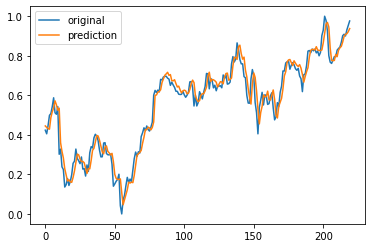

In [74]:
plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()

In [ ]:
# seq2seq

In [75]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [76]:
raw = ["I feel hungry.	나는 배가 고프다.",
       "Pytorch is very easy.	파이토치는 매우 쉽다.",
       "Pytorch is a framework for deep learning.	파이토치는 딥러닝을 위한 프레임워크이다.",
       "Pytorch is very clear to use.	파이토치는 사용하기 매우 직관적이다."]

In [77]:
# fix token for "start of sentence" and "end of sentence"
SOS_token = 0
EOS_token = 1

In [78]:
# class for vocabulary related information of data
class Vocab:
    def __init__(self):
        self.vocab2index = {"<SOS>": SOS_token, "<EOS>": EOS_token}
        self.index2vocab = {SOS_token: "<SOS>", EOS_token: "<EOS>"}
        self.vocab_count = {}
        self.n_vocab = len(self.vocab2index)

    def add_vocab(self, sentence):
        for word in sentence.split(" "):
            if word not in self.vocab2index:
                self.vocab2index[word] = self.n_vocab
                self.vocab_count[word] = 1
                self.index2vocab[self.n_vocab] = word
                self.n_vocab += 1
            else:
                self.vocab_count[word] += 1

In [79]:
# filter out the long sentence from source and target data
def filter_pair(pair, source_max_length, target_max_length):
    return len(pair[0].split(" ")) < source_max_length and len(pair[1].split(" ")) < target_max_length

In [80]:
# read and preprocess the corpus data
def preprocess(corpus, source_max_length, target_max_length):
    print("reading corpus...")
    pairs = []
    for line in corpus:
        pairs.append([s for s in line.strip().lower().split("\t")])
    print("Read {} sentence pairs".format(len(pairs)))

    pairs = [pair for pair in pairs if filter_pair(pair, source_max_length, target_max_length)]
    print("Trimmed to {} sentence pairs".format(len(pairs)))

    source_vocab = Vocab()
    target_vocab = Vocab()

    print("Counting words...")
    for pair in pairs:
        source_vocab.add_vocab(pair[0])
        target_vocab.add_vocab(pair[1])
    print("source vocab size =", source_vocab.n_vocab)
    print("target vocab size =", target_vocab.n_vocab)

    return pairs, source_vocab, target_vocab

In [81]:
# declare simple encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, x, hidden):
        x = self.embedding(x).view(1, 1, -1)
        x, hidden = self.gru(x, hidden)
        return x, hidden

In [82]:
# declare simple decoder
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        x = self.embedding(x).view(1, 1, -1)
        x, hidden = self.gru(x, hidden)
        x = self.softmax(self.out(x[0]))
        return x, hidden

In [83]:
# convert sentence to the index tensor
def tensorize(vocab, sentence):
    indexes = [vocab.vocab2index[word] for word in sentence.split(" ")]
    indexes.append(vocab.vocab2index["<EOS>"])
    return torch.Tensor(indexes).long().to(device).view(-1, 1)

In [84]:
# training seq2seq
def train(pairs, source_vocab, target_vocab, encoder, decoder, n_iter, print_every=1000, learning_rate=0.01):
    loss_total = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    training_batch = [random.choice(pairs) for _ in range(n_iter)]
    training_source = [tensorize(source_vocab, pair[0]) for pair in training_batch]
    training_target = [tensorize(target_vocab, pair[1]) for pair in training_batch]

    criterion = nn.NLLLoss()

    for i in range(1, n_iter + 1):
        source_tensor = training_source[i - 1]
        target_tensor = training_target[i - 1]

        encoder_hidden = torch.zeros([1, 1, encoder.hidden_size]).to(device)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        source_length = source_tensor.size(0)
        target_length = target_tensor.size(0)

        loss = 0

        for enc_input in range(source_length):
            _, encoder_hidden = encoder(source_tensor[enc_input], encoder_hidden)

        decoder_input = torch.Tensor([[SOS_token]]).long().to(device)
        decoder_hidden = encoder_hidden # connect encoder output to decoder input

        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # teacher forcing

        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        loss_iter = loss.item() / target_length
        loss_total += loss_iter

        if i % print_every == 0:
            loss_avg = loss_total / print_every
            loss_total = 0
            print("[{} - {}%] loss = {:05.4f}".format(i, i / n_iter * 100, loss_avg))

In [85]:
# insert given sentence to check the training
def evaluate(pairs, source_vocab, target_vocab, encoder, decoder, target_max_length):
    for pair in pairs:
        print(">", pair[0])
        print("=", pair[1])
        source_tensor = tensorize(source_vocab, pair[0])
        source_length = source_tensor.size()[0]
        encoder_hidden = torch.zeros([1, 1, encoder.hidden_size]).to(device)

        for ei in range(source_length):
            _, encoder_hidden = encoder(source_tensor[ei], encoder_hidden)

        decoder_input = torch.Tensor([[SOS_token]], device=device).long()
        decoder_hidden = encoder_hidden
        decoded_words = []

        for di in range(target_max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            _, top_index = decoder_output.data.topk(1)
            if top_index.item() == EOS_token:
                decoded_words.append("<EOS>")
                break
            else:
                decoded_words.append(target_vocab.index2vocab[top_index.item()])

            decoder_input = top_index.squeeze().detach()

        predict_words = decoded_words
        predict_sentence = " ".join(predict_words)
        print("<", predict_sentence)
        print("")

In [86]:
# declare max length for sentence
SOURCE_MAX_LENGTH = 10
TARGET_MAX_LENGTH = 12

In [89]:
import random

In [90]:
# preprocess the corpus
load_pairs, load_source_vocab, load_target_vocab = preprocess(raw, SOURCE_MAX_LENGTH, TARGET_MAX_LENGTH)
print(random.choice(load_pairs))

reading corpus...
Read 4 sentence pairs
Trimmed to 4 sentence pairs
Counting words...
source vocab size = 17
target vocab size = 13
['pytorch is very clear to use.', '파이토치는 사용하기 매우 직관적이다.']


In [91]:
# declare the encoder and the decoder
enc_hidden_size = 16
dec_hidden_size = enc_hidden_size
enc = Encoder(load_source_vocab.n_vocab, enc_hidden_size).to(device)
dec = Decoder(dec_hidden_size, load_target_vocab.n_vocab).to(device)

In [92]:
# train seq2seq model
train(load_pairs, load_source_vocab, load_target_vocab, enc, dec, 5000, print_every=1000)

[1000 - 20.0%] loss = 0.7149
[2000 - 40.0%] loss = 0.0701
[3000 - 60.0%] loss = 0.0242
[4000 - 80.0%] loss = 0.0142
[5000 - 100.0%] loss = 0.0100


In [97]:
device = 'cuda'

In [98]:
# check the model with given data
evaluate(load_pairs, load_source_vocab, load_target_vocab, enc, dec, TARGET_MAX_LENGTH)

> i feel hungry.
= 나는 배가 고프다.


RuntimeError: legacy constructor expects device type: cpu but device type: cuda was passed

In [ ]:
# PackedSequence

In [ ]:
from torch.nn.utils.rnn import pad_sequence, pack_sequence, pack_padded_sequence, pad_packed_sequence

In [ ]:
# Random word from random word generator
data = ['hello world',
        'midnight',
        'calculation',
        'path',
        'short circuit']

# Make dictionary
char_set = ['<pad>'] + list(set(char for seq in data for char in seq)) # Get all characters and include pad token
char2idx = {char: idx for idx, char in enumerate(char_set)} # Constuct character to index dictionary
print('char_set:', char_set)
print('char_set length:', len(char_set))

In [ ]:
# Convert character to index and make list of tensors
X = [torch.LongTensor([char2idx[char] for char in seq]) for seq in data]

# Check converted result
for sequence in X:
    print(sequence)

In [ ]:
# Make length tensor (will be used later in 'pack_padded_sequence' function)
lengths = [len(seq) for seq in X]
print('lengths:', lengths)

In [ ]:
# Make a Tensor of shape (Batch x Maximum_Sequence_Length)
padded_sequence = pad_sequence(X, batch_first=True) # X is now padded sequence
print(padded_sequence)
print(padded_sequence.shape)

In [ ]:
# Sort by descending lengths
sorted_idx = sorted(range(len(lengths)), key=lengths.__getitem__, reverse=True)
sorted_X = [X[idx] for idx in sorted_idx]

# Check converted result
for sequence in sorted_X:
    print(sequence)

In [ ]:
packed_sequence = pack_sequence(sorted_X)
print(packed_sequence)

In [ ]:
# one-hot embedding using PaddedSequence
eye = torch.eye(len(char_set)) # Identity matrix of shape (len(char_set), len(char_set))
embedded_tensor = eye[padded_sequence]
print(embedded_tensor.shape) # shape: (Batch_size, max_sequence_length, number_of_input_tokens)

In [ ]:
# one-hot embedding using PackedSequence
embedded_packed_seq = pack_sequence([eye[X[idx]] for idx in sorted_idx])
print(embedded_packed_seq.data.shape)

In [ ]:
# declare RNN
rnn = torch.nn.RNN(input_size=len(char_set), hidden_size=30, batch_first=True)

In [ ]:
rnn_output, hidden = rnn(embedded_tensor)
print(rnn_output.shape) # shape: (batch_size, max_seq_length, hidden_size)
print(hidden.shape)     # shape: (num_layers * num_directions, batch_size, hidden_size)

In [ ]:
rnn_output, hidden = rnn(embedded_packed_seq)
print(rnn_output.data.shape)
print(hidden.data.shape)

In [ ]:
unpacked_sequence, seq_lengths = pad_packed_sequence(embedded_packed_seq, batch_first=True)
print(unpacked_sequence.shape)
print(seq_lengths)

In [ ]:
embedded_padded_sequence = eye[pad_sequence(sorted_X, batch_first=True)]
print(embedded_padded_sequence.shape)

In [ ]:
sorted_lengths = sorted(lengths, reverse=True)
new_packed_sequence = pack_padded_sequence(embedded_padded_sequence, sorted_lengths, batch_first=True)
print(new_packed_sequence.data.shape)
print(new_packed_sequence.batch_sizes)